# Sales analysis

Import the necessary libraries

In [18]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from scipy.stats import stats
import numpy as np


In [19]:
class SalesAnalysis:
    def __init__(self,db):
      self.db=db

    def plotData(self,**inp):
        if len(inp.items())==6:

           if inp["x1"].name=="product_group_name":
               pass
           elif inp["x1"].name=="dayofyear":
               inp["x1"] = inp["x1"].astype(int)

           if inp["y1"].name=="Quantity":
               inp["y1"] = inp["y1"].astype(int)
           elif inp["y1"].name=="avg_price":
               inp["y1"] = inp["y1"].astype(float)

           if inp["y2"].name=="Quantity":
               inp["y1"] = inp["y1"].astype(int)
           elif inp["y2"].name=="avg_price":
               inp["y2"] = inp["y2"].astype(float)


           inp["ax1"].bar(inp["x1"], inp["y1"], color='green')

           inp["ax2"].plot(inp["x1"], inp["y2"],
                          color='b')

           inp["ax1"].set_xlabel(inp["x1"].name)

           inp["ax1"].set_ylabel(inp["y1"].name,color='g')

           inp["ax2"].set_ylabel(inp["y2"].name,color='b')

           inp["ax1"].set_xticklabels(inp["x1"], rotation="vertical",size=8)

           plt.show()

        else:
            if inp["x1"].name == "product_group_name":
                pass
            elif inp["x1"].name == "dayofyear":
                inp["x1"] = inp["x1"].astype(int)

            if inp["y1"].name == "Quantity":
                inp["y1"] = inp["y1"].astype(int)
            elif inp["y1"].name == "avg_price":
                inp["y1"] = inp["y1"].astype(float)
            else:
                pass

            inp["ax1"].bar(inp["x1"], inp["y1"],color='purple')

            inp["ax1"].set_xlabel(inp["x1"].name)

            inp["ax1"].set_xticks(np.arange(0, max(inp["x1"]),25))

            inp["ax1"].set_ylabel(inp["y1"].name)

            plt.show()


    def generalTrends(self):

        # Querying product_group_name,  sales grouped by product_group_name

        dfQuantity_ProductGroup=pd.read_sql("""SELECT product_group_name, SUM(items_sold) as Quantity
                           FROM sales 
                           GROUP BY product_group_name""",self.db)


        # Querying average prices, product_group_names, grouped by product_group_name

        dfAvgPrice_ProductGroup = pd.read_sql("""SELECT AVG(price_after_discount) as avg_price, product_group_name 
                             FROM sales GROUP BY product_group_name""", self.db)

        # Plotting the queries

        fig1,ax1=plt.subplots()

        ax2 = ax1.twinx()

        self.plotData(fig1=fig1, ax1= ax1, ax2= ax2, x1 = dfQuantity_ProductGroup['product_group_name'],
                         y1=dfQuantity_ProductGroup['Quantity'], y2=dfAvgPrice_ProductGroup['avg_price'])



        # Querying quantities, dayofyear grouped by dayoyear

        dfQuantity_Days = pd.read_sql("""SELECT SUM(items_sold) as Quantity, dayofyear 
                                  FROM sales GROUP BY dayofyear""",self.db)

        dayofyear=dfQuantity_Days["dayofyear"]

        # Plotting the queries

        fig2, ax3 = plt.subplots()

        self.plotData(fig1=fig2, ax1=ax3, x1=dayofyear, y1=dfQuantity_Days["Quantity"])



        # Querying price_after_discount, sum(items_sold) grouped by dayfyear and price_after_discount

        dfQuantity_Days= pd.read_sql("""SELECT COUNT(price_after_discount), price_after_discount,dayofyear, SUM(items_sold),
                             SUM(items_sold) * price_after_discount as Quantity
                             FROM sales 
                             GROUP BY dayofyear, price_after_discount """,
                          self.db)


        Revenue = dfQuantity_Days.groupby('dayofyear')['Quantity'].sum()

        Revenue.name = 'Revenue'

        # Plotting the queries

        fig3, ax4 = plt.subplots()

        self.plotData(fig1=fig3, ax1=ax4,x1=dayofyear,y1=Revenue)

        return



    def productsBehavior(self):

        df_alldata = pd.read_sql(""" SELECT * FROM sales""",self.db)

        unique_products = df_alldata['product_group_name'].unique()

        unique_products = unique_products.tolist()


        while len(unique_products) > 1:

            temp = unique_products.pop()

            # Querying sales and days grouped by product_group_name and day

            dfQuantity_Days = pd.read_sql(""" SELECT SUM(items_sold) as Quantity, dayofyear
               FROM sales GROUP BY dayofyear, product_group_name  
               HAVING product_group_name='{0}'
               """.format(temp), self.db)

            # Converting data dtype to integer

            dfQuantity_Days["dayofyear"] = dfQuantity_Days["dayofyear"].astype(int)
            #
            dfQuantity_Days["Quantity"] = dfQuantity_Days["Quantity"].astype(int)

            # Querying average prices and days grouped by product_group_name and day

            dfAvgPrice_Days = pd.read_sql(""" SELECT AVG(price_after_discount) as avg_price, dayofyear
                      FROM sales GROUP BY dayofyear, product_group_name  
                      HAVING product_group_name='{0}'
                      """.format(temp), self.db)

            # Converting data dtype to integer

            dfAvgPrice_Days["dayofyear"] = dfAvgPrice_Days["dayofyear"].astype(int)
            #
            dfAvgPrice_Days["avg_price"] = dfAvgPrice_Days["avg_price"].astype(int)



            fig3, ax1 = plt.subplots()

            ax2 = ax1.twinx()

            ax1.bar(dfQuantity_Days['dayofyear'],dfQuantity_Days['Quantity'],color='blue')

            ax2.plot(dfAvgPrice_Days['dayofyear'],dfAvgPrice_Days['avg_price'], 'g-')

            ax1.set_xlabel('dayofyear')

            ax1.set_xticks(np.arange(0, max(dfQuantity_Days['dayofyear']), 25))

            ax1.set_ylabel('Quantity', color='blue')

            ax2.set_ylabel('avg_price (EURO)', color='g')

            ax1.set_title(temp)


            plt.show()


            fig4, ax3 = plt.subplots()

            dfDiscount_Days = pd.read_sql("""SELECT discount, dayofyear FROM sales
                             GROUP BY dayofyear, product_group_name  
                             HAVING product_group_name='{0}'
                            """.format(temp), self.db)

            dfDiscount_Days['discount'] = dfDiscount_Days["discount"].astype(float)


            ax3.set_xlabel('discount')

            ax3.set_ylabel('Quantity')

            plt.scatter(dfDiscount_Days['discount'],dfQuantity_Days['Quantity'],
                        label=temp, color='red')

            ax3.set_title(temp)

            corr,_= stats.pearsonr(dfDiscount_Days['discount'],dfQuantity_Days['Quantity'])

            print("Pearson correlation coefficient: {0}".format(corr))

            plt.show()


            break

    def optPrice(self):

        df = pd.read_sql(""" SELECT DISTINCT(product_id) FROM sales
                        WHERE product_group_name='Jeans'
                       """,self.db)

        unique_productId = df['product_id']

        unique_productId = unique_productId.tolist()

        Slopes, Intercepts,Std, Rvalue, Temp,Pvalue = [], [], [], [], [], []

        while len(unique_productId) >= 1:
            temp = unique_productId.pop()

            df = pd.read_sql("""SELECT price_after_discount, items_sold, items_left_in_stocks, product_id FROM sales
                                GROUP BY  price_after_discount, dayofyear,product_id, product_group_name
                                HAVING product_group_name='Jeans' and product_id={0}""".format(temp), self.db)


            df["price_after_discount"] = df["price_after_discount"].astype(float)

            df["items_sold"] = df["items_sold"].astype(float)

            slope, intercept, r, p,std_err = stats.linregress(df["price_after_discount"],df["items_sold"])

            Slopes.extend([slope])

            Intercepts.extend([intercept])

            Rvalue.extend([r])

            Std.extend([std_err])

            Temp.extend([temp])

            Pvalue.extend([p])

        df = pd.DataFrame(list(zip(Temp,Slopes, Intercepts,Rvalue,Pvalue, Std)),
                          columns=['id', 'Slope', 'Intercept','Rvalue','Pvalue','std'])

        return df




In [20]:
from processingData import cleanData, createTable


# Data processing

filename='data.parquet'

df = cleanData(filename)

db = createTable(df)

db = createTable(df)
import pandas as pd


There are 324610 rows and 17 columns
There are Nan( or None) in season
Now there are 261871 rows and 17 columns
table sales already exists
table sales already exists


/home/gianni/PycharmProjects/cryptocurrency_analysis/python_projects/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


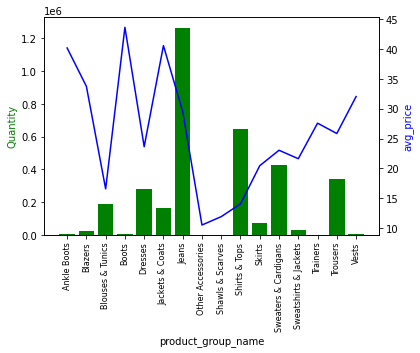

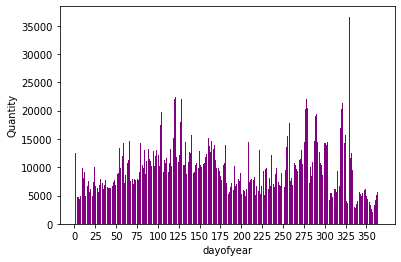

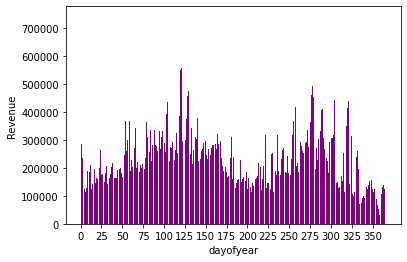

In [21]:
# Initializing the SalesAnalysis classs


SalesAnalysis = SalesAnalysis(db)

SalesAnalysis.generalTrends()

#What was the best selling product?

#What was the best month for sales

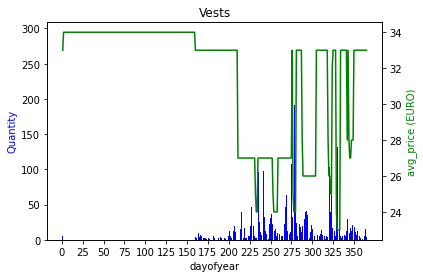

Pearson correlation coefficient: 0.5132148582836272


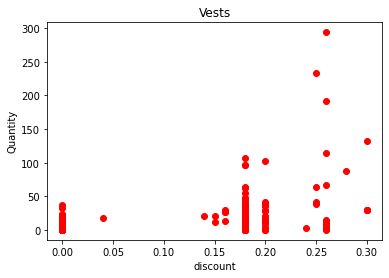

,id,Slope,Intercept,Rvalue,Pvalue,std
0,8254,-0.062172,4.827756,-0.069932,1.931019e-01,0.047678
1,9657,1.329536,-23.196979,0.359182,4.536845e-08,0.234511
2,352,-2.049740,59.305057,-0.408026,4.082177e-16,0.240390
3,12230,0.631331,7.505022,0.047154,7.349161e-01,1.854597
4,12518,-1.452766,51.696487,-0.580283,2.528912e-34,0.106869
...,...,...,...,...,...,...
165,6034,-1.559019,62.849527,-0.198272,1.373396e-04,0.404509
166,4458,2.060709,-35.841548,0.260895,4.147220e-07,0.399662
167,3869,0.400526,-5.100948,0.206457,6.915001e-05,0.099493
168,10123,-3.408679,105.429386,-0.690721,2.022442e-27,0.264520


In [22]:
# Why the best product sales are on December?

SalesAnalysis.productsBehavior()

SalesAnalysis.optPrice()
